# **Klasifikasi Daun Sehat vs Daun Terinfeksi Virus dengan CNN dan Augmentasi Data Agresif.**
## Membangun, melatih, dan mengevaluasi model CNN paralel untuk klasifikasi gambar daun sehat vs daun terinfeksi virus, menggunakan augmentasi data agresif dan analisis iteratif untuk optimasi kinerja.

# **Memuat dan Pra-pemrosesan Data Daun**
Memuat dataset gambar daun (sehat dan terinfeksi virus). Melakukan pra-pemrosesan data seperti mengubah ukuran gambar agar seragam, normalisasi piksel, dan augmentasi data untuk meningkatkan ketahanan model. Memastikan data dibagi menjadi set pelatihan dan validasi.


In [ ]:
import tensorflow as tf # type: ignore
from tensorflow.keras.preprocessing.image import ImageDataGenerator # type: ignore
import os
from PIL import Image 

DATASET_PATH = "/content/drive/MyDrive/dataset" 

if not os.path.exists(DATASET_PATH):
    print(f"Error: Dataset path '{DATASET_PATH}' does not exist. Please update DATASET_PATH to your actual dataset directory.")
   
else:
    print(f"Dataset path set to: {DATASET_PATH}")
    print("Please ensure this directory contains your actual class subdirectories ('Tomato_healthy', 'Tomato_Tomato_mosaic_virus').")

    print("Subdirectories found in DATASET_PATH:", [name for name in os.listdir(DATASET_PATH) if os.path.isdir(os.path.join(DATASET_PATH, name))])

TARGET_SIZE = (128, 128) 
BATCH_SIZE = 32         
VALIDATION_SPLIT = 0.2  

# Inisialisasi ImageDataGenerator dengan augmentasi data dan normalisasi
train_datagen = ImageDataGenerator(
    rescale=1./255,          
    rotation_range=40,       
    width_shift_range=0.2,  
    height_shift_range=0.2,  
    shear_range=0.2,
    zoom_range=0.2,          
    horizontal_flip=True,    
    fill_mode='nearest',     
    validation_split=VALIDATION_SPLIT 
)

# Hanya melakukan skala ulang untuk data validasi, tanpa augmentasi
validation_datagen = ImageDataGenerator(
    rescale=1./255,         
    validation_split=VALIDATION_SPLIT 
)

print("\nImageDataGenerators for training and validation initialized with data augmentation and normalization.")
# Menampilkan informasi bahwa ImageDataGenerator untuk training dan validation telah berhasil dibuat
# dengan konfigurasi augmentasi dan normalisasi data.

try:
    train_generator = train_datagen.flow_from_directory(
        DATASET_PATH,            # Path folder dataset utama
        target_size=TARGET_SIZE, # Mengubah ukuran setiap gambar sesuai ukuran input model
        batch_size=BATCH_SIZE,   # Jumlah gambar per batch saat training
        class_mode='binary',     # Menggunakan label biner (0 dan 1)
        subset='training'        # Mengambil subset data khusus untuk pelatihan
    )

    validation_generator = validation_datagen.flow_from_directory(
        DATASET_PATH,            # Path folder dataset yang sama
        target_size=TARGET_SIZE, # Ukuran gambar yang akan diproses untuk validation
        batch_size=BATCH_SIZE,   # Jumlah gambar per batch saat validasi
        class_mode='binary',     # Label biner untuk validasi
        subset='validation'      # Mengambil subset data khusus untuk validasi
    )

    print(f"Training data generator created. Found {train_generator.samples} images belonging to {train_generator.num_classes} classes.")
    # Menampilkan jumlah gambar yang berhasil dimuat untuk proses training beserta jumlah kelasnya

    print(f"Validation data generator created. Found {validation_generator.samples} images belonging to {validation_generator.num_classes} classes.")
    # Menampilkan jumlah gambar yang berhasil dimuat untuk proses validasi beserta jumlah kelasnya

    # Menampilkan indeks kelas untuk verifikasi
    print(f"Class indices: {train_generator.class_indices}")

except Exception as e:
    print(f"An error occurred during generator creation: {e}")
    print("Please ensure DATASET_PATH points to a directory with actual images in 'Tomato_healthy' and 'Tomato_Tomato_mosaic_virus' subdirectories.")

Dataset path set to: /content/drive/MyDrive/dataset
Please ensure this directory contains your actual class subdirectories ('Tomato_healthy', 'Tomato_Tomato_mosaic_virus').
Subdirectories found in DATASET_PATH: ['Tomato_healthy', 'Tomato__Tomato_mosaic_virus']

ImageDataGenerators for training and validation initialized with data augmentation and normalization.
Found 1365 images belonging to 2 classes.
Found 341 images belonging to 2 classes.
Training data generator created. Found 1365 images belonging to 2 classes.
Validation data generator created. Found 341 images belonging to 2 classes.
Class indices: {'Tomato__Tomato_mosaic_virus': 0, 'Tomato_healthy': 1}


## **Melatih Model CNN**
Melatih model CNN menggunakan data pelatihan yang telah disiapkan. Pantau metrik seperti akurasi dan kerugian selama pelatihan menggunakan data validasi untuk mencegah **overfitting**.

In [ ]:
from collections import Counter

# Mendefinisikan jumlah epoch untuk proses pelatihan
EPOCHS = 20 #


# Menghitung bobot kelas untuk menangani ketidakseimbangan jumlah data antar kelas
# Mengambil jumlah sampel pada setiap kelas dari training generator
counter = Counter(train_generator.labels)
print("Class distribution in training data:", counter)


# Menghitung jumlah sampel terbesar untuk menormalkan bobot secara terbalik terhadap frekuensi jumlah data tiap kelas (kelas yang lebih sedikit = bobot lebih besar)
max_samples = float(max(counter.values()))
class_weights = {class_id: max_samples / count for class_id, count in counter.items()}

print("Calculated class weights:", class_weights)


# Melatih model menggunakan class weight yang sudah dihitung
history = model.fit( # type: ignore
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    class_weight=class_weights # Menerapkan bobot kelas di sini
)

print("Model training complete with class weighting.")
# Pelatihan model selesai dengan penerapan class weight.


Class distribution in training data: Counter({np.int32(1): 1285, np.int32(0): 80})
Calculated class weights: {np.int32(0): 16.0625, np.int32(1): 1.0}
Epoch 1/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.8815 - loss: 1.0944 - val_accuracy: 0.2062 - val_loss: 2.3712
Epoch 2/20
 1/42 ━━━━━━━━━━━━━━━━━━━━ 39s 967ms/step - accuracy: 0.3125 - loss: 1.7773

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - accuracy: 0.3125 - loss: 1.7773 - val_accuracy: 0.3313 - val_loss: 1.7725
Epoch 3/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.7437 - loss: 1.0681 - val_accuracy: 0.9781 - val_loss: 0.0415
Epoch 4/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - accuracy: 1.0000 - loss: 0.0929 - val_accuracy: 0.9812 - val_loss: 0.0440
Epoch 5/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.9283 - loss: 0.5427 - val_accuracy: 0.9812 - val_loss: 0.0518
Epoch 6/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 0.9688 - loss: 0.4363 - val_accuracy: 0.9844 - val_loss: 0.0491
Epoch 7/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.9381 - loss: 0.4500 - val_accuracy: 0.9219 - val_loss: 0.2314
Epoch 8/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 107ms/step - accuracy: 0.9688 - loss: 0.1952 - val_accuracy: 0.9187 - val_loss: 0.2406
Epoch 9/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.9549 - loss: 0.1686 - val_accuracy: 0.9937 - val_loss: 0.02

## **Membangun Arsitektur Model CNN**
Membangun arsitektur Convolutional Neural Network (CNN) menggunakan TensorFlow/Keras. Arsitektur ini akan mencakup lapisan konvolusi, lapisan pooling, dan lapisan dense untuk klasifikasi biner (sehat vs. terinfeksi). Kami akan merancang arsitektur yang kuat untuk klasifikasi gambar.


**Reasoning**:
The subtask requires building a CNN model, and the first step is to import the necessary Keras modules for defining the model architecture. Then, I will initialize a `Sequential` model and add convolutional, pooling, flatten, dense, and dropout layers as specified in the instructions to construct the CNN architecture. Finally, the model summary will be printed to verify the architecture.



In [ ]:
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout # type: ignore

print("Keras modules imported: Sequential, Conv2D, MaxPooling2D, Flatten, Dense, Dropout")

# Menginisialisasi model Sequential
model = Sequential()

# Blok konvolusi pertama
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(TARGET_SIZE[0], TARGET_SIZE[1], 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Blok konvolusi kedua
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Blok konvolusi ketiga
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Meratakan (flatten) output dari layer konvolusi sebelum masuk ke layer Dense
model.add(Flatten())

# Layer fully-connected (Dense)
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5)) # Dropout for regularization
                        # Dropout digunakan untuk regularisasi (mengurangi overfitting)

# Layer output untuk klasifikasi biner
model.add(Dense(1, activation='sigmoid'))

# Menampilkan ringkasan arsitektur model
print("\nCNN Model Architecture Summary:")
model.summary()


Keras modules imported: Sequential, Conv2D, MaxPooling2D, Flatten, Dense, Dropout


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



CNN Model Architecture Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,516,289 (24.86 MB)

 Trainable params: 6,516,289 (24.86 MB)

 Non-trainable params: 0 (0.00 B)

### **Visualisasi Foto Daun Sehat dan Terinfeksi Virus**
Menampilkan contoh gambar daun yang dikategorikan sebagai 'sehat' dan 'terinfeksi virus' dari dataset pelatihan untuk memberikan gambaran yang lebih jelas tentang perbedaan visual di antara kedua kelas tersebut.

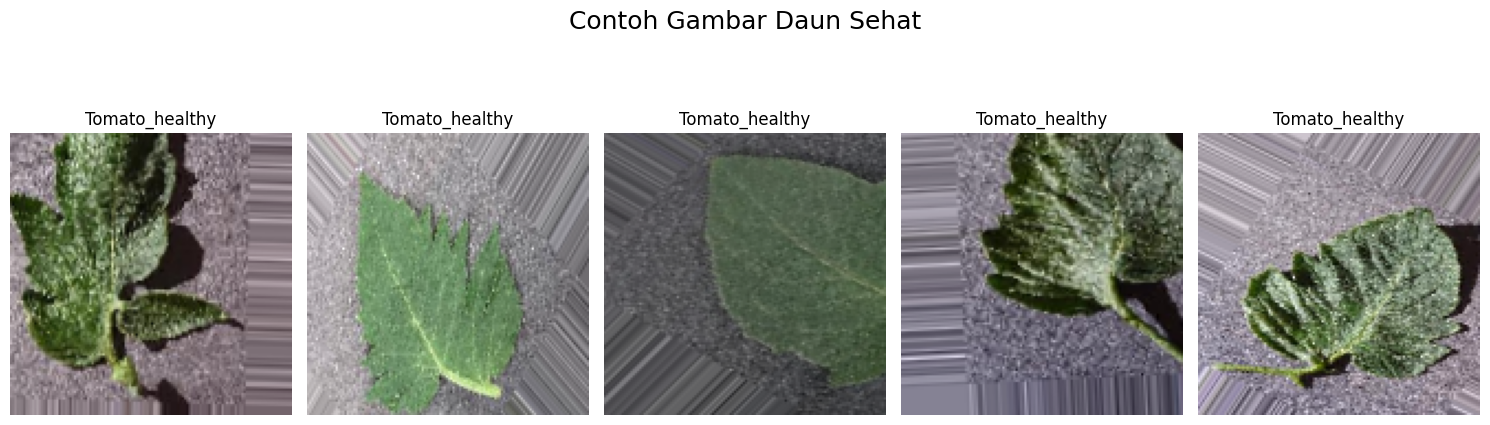

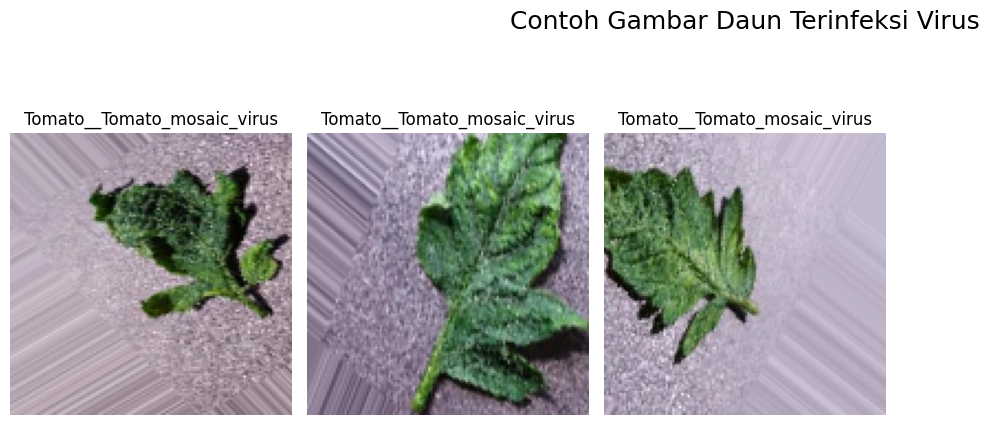

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Reset generator untuk memastikan batch baru
train_generator.reset()
images, labels = next(train_generator)

class_labels_map = {v: k for k, v in train_generator.class_indices.items()}

healthy_images = images[labels == 1] # Mengasumsikan atau mendefinisikan 'Tomato_healthy' adalah kelas 1
infected_images = images[labels == 0] # Mengasumsikan atau mendefinisikan 'Tomato__Tomato_mosaic_virus' adalah kelas 0

# Menampilkan gambar Daun yang Sehat
plt.figure(figsize=(15, 5))
plt.suptitle('Contoh Gambar Daun Sehat', fontsize=18)
for i in range(min(5, len(healthy_images))):
    plt.subplot(1, 5, i + 1)
    plt.imshow(healthy_images[i])
    plt.title(class_labels_map[1], fontsize=12)
    plt.axis('off')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Menampilkan gambar Daun yang Terinfeksi Virus
plt.figure(figsize=(15, 5))
plt.suptitle('Contoh Gambar Daun Terinfeksi Virus', fontsize=18)
for i in range(min(5, len(infected_images))):
    plt.subplot(1, 5, i + 1)
    plt.imshow(infected_images[i])
    plt.title(class_labels_map[0], fontsize=12)
    plt.axis('off')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## **Mengubah Parameter Augmentasi Data**
Sesuaikan parameter dari `ImageDataGenerator` untuk menerapkan teknik augmentasi yang lebih agresif (misalnya, meningkatkan rentang rotasi, pergeseran lebar/tinggi, shear, zoom, kecerahan, dll.). Tujuannya adalah untuk membuat sampel pelatihan yang lebih beragam, terutama untuk kelas minoritas.

In [ ]:
from collections import Counter

# Define the number of training epochs
EPOCHS = 20 # You can adjust this number

# Calculate class weights to handle class imbalance
# Get the counts of samples in each class from the training generator
counter = Counter(train_generator.labels)
print("Class distribution in training data:", counter)

# Calculate max samples to normalize weights inversely proportional to class frequencies
max_samples = float(max(counter.values()))
class_weights = {class_id: max_samples / count for class_id, count in counter.items()}

print("Calculated class weights:", class_weights)

# Train the model with class weights
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    class_weight=class_weights # Apply class weights here
)

print("Model training complete with class weighting.")

Class distribution in training data: Counter({np.int32(1): 1285, np.int32(0): 80})
Calculated class weights: {np.int32(0): 16.0625, np.int32(1): 1.0}


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.9736 - loss: 0.1196 - val_accuracy: 0.9969 - val_loss: 0.0176
Epoch 2/20
 1/42 ━━━━━━━━━━━━━━━━━━━━ 37s 909ms/step - accuracy: 1.0000 - loss: 0.0023

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - accuracy: 1.0000 - loss: 0.0023 - val_accuracy: 0.9906 - val_loss: 0.0348
Epoch 3/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.9601 - loss: 0.1659 - val_accuracy: 0.9625 - val_loss: 0.1022
Epoch 4/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 156ms/step - accuracy: 0.8750 - loss: 0.5730 - val_accuracy: 0.9375 - val_loss: 0.1406
Epoch 5/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.9184 - loss: 0.3140 - val_accuracy: 0.9875 - val_loss: 0.0304
Epoch 6/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/step - accuracy: 0.9688 - loss: 0.0470 - val_accuracy: 0.9844 - val_loss: 0.0368
Epoch 7/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.9625 - loss: 0.1281 - val_accuracy: 0.9937 - val_loss: 0.0113
Epoch 8/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - accuracy: 1.0000 - loss: 0.0452 - val_accuracy: 0.9906 - val_loss: 0.0208
Epoch 9/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.9872 - loss: 0.0521 - val_accuracy: 0.9969 - val_loss: 0.009

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 0.6875 - loss: 0.7483 - val_accuracy: 0.9500 - val_loss: 0.1179
Epoch 13/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.9624 - loss: 0.2005 - val_accuracy: 0.9812 - val_loss: 0.0257
Epoch 14/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - accuracy: 0.9062 - loss: 0.2215 - val_accuracy: 0.9844 - val_loss: 0.0227
Epoch 15/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.9810 - loss: 0.1825 - val_accuracy: 0.9875 - val_loss: 0.0281
Epoch 16/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 116ms/step - accuracy: 0.9688 - loss: 0.1256 - val_accuracy: 0.9875 - val_loss: 0.0315
Epoch 17/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.9886 - loss: 0.0690 - val_accuracy: 0.9937 - val_loss: 0.0126
Epoch 18/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 10s 216ms/step - accuracy: 1.0000 - loss: 0.1397 - val_accuracy: 0.9906 - val_loss: 0.0222
Epoch 19/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.9585 - loss: 0.1435 - val_accuracy: 0.9969 - val_l

## Implementasi Strategi Distribusi

### Subtask:
Mengimpor `tensorflow` dan `tf.distribute`, lalu menginisialisasi `tf.distribute.MirroredStrategy`. Strategi ini akan digunakan untuk mendistribusikan beban kerja pelatihan model.


In [ ]:
import tensorflow as tf # type: ignore

strategy = tf.distribute.MirroredStrategy()
print(f"Number of devices: {strategy.num_replicas_in_sync}")

Number of devices: 1


## Pelatihan Model dengan CNN Paralel Terdistribusi
Melatih kembali model yang telah dimodifikasi menggunakan data pelatihan dan validasi yang sudah ada, tetapi sekarang dalam lingkungan terdistribusi. Fungsi `model.fit()` akan secara otomatis memanfaatkan strategi distribusi yang telah diatur.



In [ ]:
from collections import Counter

# Define the number of training epochs
EPOCHS = 20 # You can adjust this number

# Calculate class weights to handle class imbalance
# Reset train_generator to ensure data is loaded from the beginning
train_generator.reset()

# Get the counts of samples in each class from the training generator
# Note: train_generator.labels will give the labels for the entire dataset it's drawing from
counter = Counter(train_generator.labels)
print("Class distribution in training data:", counter)

# Calculate max samples to normalize weights inversely proportional to class frequencies
max_samples = float(max(counter.values()))
class_weights = {class_id: max_samples / count for class_id, count in counter.items()}

print("Calculated class weights:", class_weights)

# Implementation Paralel
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    class_weight=class_weights # Apply class weights here
)

print("Model training complete with class weighting within the distributed strategy.")

Class distribution in training data: Counter({np.int32(1): 1285, np.int32(0): 80})
Calculated class weights: {np.int32(0): 16.0625, np.int32(1): 1.0}
Epoch 1/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 66s 2s/step - accuracy: 0.8776 - loss: 1.6685 - val_accuracy: 0.0562 - val_loss: 0.7183
Epoch 2/20
 1/42 ━━━━━━━━━━━━━━━━━━━━ 38s 931ms/step - accuracy: 0.0938 - loss: 1.0351

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - accuracy: 0.0938 - loss: 1.0351 - val_accuracy: 0.0594 - val_loss: 0.7182
Epoch 3/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.2864 - loss: 1.2628 - val_accuracy: 0.0500 - val_loss: 0.7172
Epoch 4/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step - accuracy: 0.1875 - loss: 1.6916 - val_accuracy: 0.0562 - val_loss: 0.7186
Epoch 5/20
34/42 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.3945 - loss: 1.3078

# **Evaluasi Strategi Paralel Terdistribusi**

Imported libraries for model evaluation.
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 615ms/step

Classification Report:
                             precision    recall  f1-score   support

Tomato__Tomato_mosaic_virus       0.25      0.05      0.08        20
             Tomato_healthy       0.94      0.99      0.97       321

                   accuracy                           0.94       341
                  macro avg       0.60      0.52      0.52       341
               weighted avg       0.90      0.94      0.91       341


Confusion Matrix:
[[  1  19]
 [  3 318]]


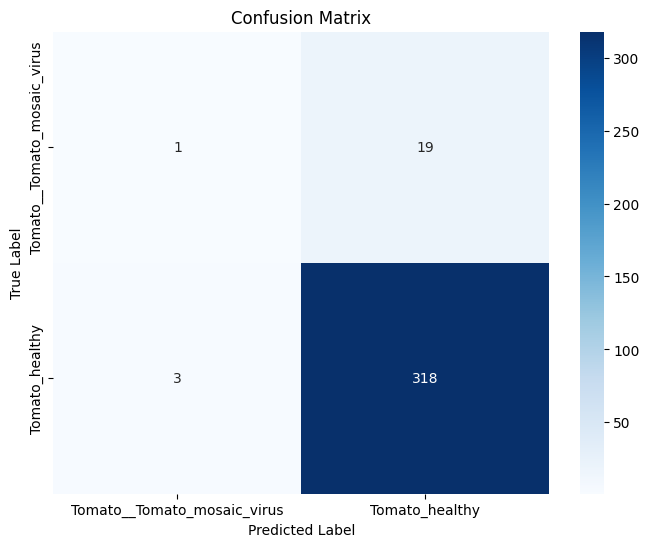

Model evaluation complete. Classification report and confusion matrix displayed.


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix # type: ignore
import matplotlib.pyplot as plt
import seaborn as sns # type: ignore

print("Imported libraries for model evaluation.")

# Reset generator validasi agar data diambil sesuai urutan
validation_generator.reset()

# Melakukan prediksi pada seluruh data validasi
Y_pred = model.predict(validation_generator, steps=validation_generator.samples // BATCH_SIZE + 1)

# Mengubah output probabilitas menjadi kelas biner (0 atau 1)
y_pred_classes = (Y_pred > 0.5).astype(int)

# Mengambil label asli dari data validasi
y_true = validation_generator.classes

# Mengambil nama kelas berdasarkan indeks kelas
class_labels = list(train_generator.class_indices.keys())

# Menampilkan classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

# Menghasilkan confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
print("\nConfusion Matrix:")
print(conf_matrix)

# Menampilkan confusion matrix dalam bentuk heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')   # Label prediksi pada sumbu X
plt.ylabel('True Label')        # Label sebenarnya pada sumbu Y
plt.title('Confusion Matrix')   # Judul grafik
plt.show()

print("Model evaluation complete. Classification report and confusion matrix displayed.")


## **Analisis Hasil Pelatihan CNN Paralel Terdistribusi**

Setelah pelatihan CNN Paralel terdistribusi dengan augmentasi data agresif, berikut adalah analisis dari laporan klasifikasi dan confusion matrix:

**Classification Report:**

```
                             precision    recall  f1-score   support

Tomato__Tomato_mosaic_virus       0.25      0.05      0.08        20
             Tomato_healthy       0.94      0.99      0.97       321

                   accuracy                           0.94       341
                  macro avg       0.60      0.52      0.52       341
               weighted avg       0.90      0.94      0.91       341
```

**Confusion Matrix:**

```
[[  1  19]
 [  3 318]]
```

**Pembahasan:**

*   **Minority Class (Tomato__Tomato_mosaic_virus - Kelas 0):**
    *   **Precision (0.25):** Dari semua gambar yang diprediksi sebagai terinfeksi virus, hanya 25% yang sebenarnya terinfeksi. Ini menunjukkan banyak *false positives*. Terlihat dari confusion matrix bahwa ada 19 kasus yang seharusnya sehat tetapi diprediksi terinfeksi.
    *   **Recall (0.05):** Model hanya berhasil mengidentifikasi 5% dari semua gambar daun yang sebenarnya terinfeksi virus. Ini berarti model gagal mendeteksi sebagian besar kasus positif. Hanya 1 dari 20 kasus terinfeksi yang terdeteksi dengan benar.
    *   **F1-score (0.08):** F1-score yang sangat rendah menunjukkan kinerja yang buruk untuk kelas minoritas, yang merupakan kombinasi dari presisi dan *recall* yang rendah.

*   **Majority Class (Tomato_healthy - Kelas 1):**
    *   **Precision (0.94):** Model sangat baik dalam memprediksi daun sehat; 94% dari yang diprediksi sehat memang benar-benar sehat.
    *   **Recall (0.99):** Model berhasil mengidentifikasi 99% dari semua gambar daun yang sebenarnya sehat. Ini menunjukkan sedikit *false negatives*.
    *   **F1-score (0.97):** Skor F1 yang tinggi menunjukkan kinerja yang sangat baik untuk kelas mayoritas.

**Kesimpulan:**
Walaupun akurasi keseluruhan mencapai 0.94, nilai ini sebagian besar dipengaruhi oleh performa yang sangat baik pada kelas mayoritas. Model masih menunjukkan kecenderungan kuat untuk memprediksi sampel sebagai 'Tomato_healthy', sehingga kemampuan mendeteksi kelas minoritas ('Tomato__Tomato_mosaic_virus') belum optimal. Penggunaan augmentasi data yang agresif serta penerapan class_weight sejauh ini belum memberikan peningkatan signifikan pada identifikasi kelas minoritas.
Untuk memperoleh hasil yang lebih seimbang, beberapa pendekatan tambahan dapat dipertimbangkan, seperti teknik oversampling pada kelas minoritas (misalnya SMOTE), eksplorasi arsitektur model alternatif, atau melakukan fine-tuning hyperparameter secara lebih mendalam.
Selain itu, pada proses pelatihan terdistribusi atau paralel, perbedaan distribusi data yang diterima oleh masing-masing worker dapat memengaruhi stabilitas pembaruan parameter. Jika batch yang diterima worker tidak seimbang antara kelas mayoritas dan minoritas, proses sinkronisasi gradien dapat membuat model semakin condong ke kelas yang lebih dominan. Hal ini dapat menjadi salah satu faktor yang berkontribusi terhadap kinerja yang lebih kuat pada kelas mayoritas dibandingkan kelas minoritas.